In [2]:
import os
import time
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, balanced_accuracy_score, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.backends import cudnn
cudnn.deterministic = True
cudnn.benchmark = False
device = torch.device('cuda') if torch.cuda.is_available() else roech.device('cpu')

In [4]:
from option import get_option, parser
from trainer import Trainer
from utils import save_option
import data_loader
import models
from urlnet_utils import *

In [5]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
#logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger(__name__)

import warnings
warnings.filterwarnings("ignore")
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
def set_seed(seed=87):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(87)

# process data

In [8]:
min_word_freq = 20
max_len_words = 200
max_len_chars = 200
max_len_subwords = 20
delimit_mode = 1
dev_pct = 0.01

In [9]:
urls, labels = read_data("../URLNet/train_10000.txt")

high_freq_words = None
if min_word_freq > 0:
    x1, word_reverse_dict = get_word_vocab(urls, max_len_words, min_word_freq) 
    high_freq_words = sorted(list(word_reverse_dict.values()))
    print("Number of words with freq >={}: {}".format(min_word_freq, len(high_freq_words)))

x, word_reverse_dict = get_word_vocab(urls, max_len_words)
word_x = get_words(x, word_reverse_dict, delimit_mode, urls)
ngramed_id_x, ngrams_dict, worded_id_x, words_dict = ngram_id_x(word_x, max_len_subwords, high_freq_words)
reverse_dict = {words_dict[i]:i for i in words_dict}
print("Overall Mal/Ben rate: {}/{}".format(np.sum(labels==1), np.sum(labels==0)))

########  shuffle & split  ######

shuffle_idx = np.random.permutation(np.arange(len(labels)))
train, test = prep_train_test(len(labels), dev_pct)
#y_train, y_test = to_categorical(labels[train], nb_classes=2), to_categorical(labels[test], nb_classes=2)
y_train, y_val = labels[train], labels[test]

x_train_word = pad_seq_in_word(worded_id_x[train], max_len_words)
x_val_word = pad_seq_in_word(worded_id_x[test], max_len_words)
print(x_train_word.shape, x_val_word.shape)


########  characters  ######
#chars_dict = ngrams_dict
#chared_id_x = char_id_x(urls, chars_dict, max_len_chars)
#x_train_char = ngramed_id_x[train]
#x_val_char = ngramed_id_x[test]
#x_train_char_seq = pad_seq_in_word(chared_id_x[train], max_len_chars)
#x_val_char_seq = pad_seq_in_word(chared_id_x[test], max_len_chars)
#print(x_train_char_seq.shape, x_val_char_seq.shape)

01/19/2020 17:16:03 - WARNING - tensorflow -   From /host/Proxy/learning-not-to-learn/urlnet_utils.py:113: VocabularyProcessor.__init__ (from tensorflow.contrib.learn.python.learn.preprocessing.text) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tensorflow/transform or tf.data.
01/19/2020 17:16:03 - WARNING - tensorflow -   From /usr/local/lib/python3.5/dist-packages/tensorflow/contrib/learn/python/learn/preprocessing/text.py:154: CategoricalVocabulary.__init__ (from tensorflow.contrib.learn.python.learn.preprocessing.categorical_vocabulary) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tensorflow/transform or tf.data.
01/19/2020 17:16:03 - WARNING - tensorflow -   From /usr/local/lib/python3.5/dist-packages/tensorflow/contrib/learn/python/learn/preprocessing/text.py:170: tokenizer (from tensorflow.contrib.learn.python.learn.preprocessing.text) is deprecated and will be removed in a future ver

Finished build vocabulary and mapping to x in 2.5176048278808594
Size of word vocabulary: 1676
Number of words with freq >=20: 1676
Finished build vocabulary and mapping to x in 2.328479766845703
Size of word vocabulary: 63443
Processing #url 0
Size of ngram vocabulary: 131
Size of word vocabulary: 1733
Index of <UNKNOWN> word: 4
Overall Mal/Ben rate: 23613/23613
(46754, 200) (472, 200)


In [11]:
urls, labels = read_data("../URLNet/val_10000.txt")
x, word_reverse_dict = get_word_vocab(urls, max_len_words) 
word_x = get_words(x, word_reverse_dict, delimit_mode, urls) 
ngramed_id_x, worded_id_x = ngram_id_x_from_dict(word_x, max_len_subwords, ngrams_dict, words_dict) 
print("Number of testing urls: {}".format(len(labels)))

y_test = labels
x_test_word = pad_seq_in_word(worded_id_x, max_len_words)
print(x_test_word.shape)

########  characters  ######
#chared_id_x = char_id_x(urls, chars_dict, max_len_chars)
#x_test_char = ngramed_id_x
#x_test_char_seq = pad_seq_in_word(chared_id_x, max_len_chars)
#print(x_test_char_seq.shape, x_test_char_seq.shape)

Finished build vocabulary and mapping to x in 0.24662184715270996
Size of word vocabulary: 10884
Index of <UNKNOWN> word: 4
Processing url #0
Number of testing urls: 5248
(5248, 200)


In [13]:
# from different data source
# main evaluation

urls, labels = read_data("../taipei/out.csv")

### balance ###
n_subsample = min((labels==1).sum(), (labels==0).sum())
murl = urls[labels==0]
burl = urls[labels==1]
np.random.shuffle(murl)
np.random.shuffle(burl)
urls = np.concatenate([murl[:n_subsample], burl[:n_subsample]])
labels = np.array([0]*n_subsample+[1]*n_subsample)
print("balance", len(urls), len(labels))
###
x, word_reverse_dict = get_word_vocab(urls, max_len_words) 
word_x = get_words(x, word_reverse_dict, delimit_mode, urls) 
ngramed_id_x, worded_id_x = ngram_id_x_from_dict(word_x, max_len_subwords, ngrams_dict, words_dict)
print("Number of testing urls: {}".format(len(labels)))

y_test2 = labels
x_test_word2 = pad_seq_in_word(worded_id_x, max_len_words)
print(x_test_word2.shape)

########  characters  ######
#chared_id_x = char_id_x(urls, chars_dict, max_len_chars)
#x_test_char2 = ngramed_id_x
#x_test_char_seq2 = pad_seq_in_word(chared_id_x, max_len_chars)
#print(x_test_char_seq2.shape, x_test_char_seq2.shape)

balance 132894 132894
Finished build vocabulary and mapping to x in 5.991540908813477
Size of word vocabulary: 186707
Index of <UNKNOWN> word: 4
Processing url #0
Processing url #100000
Number of testing urls: 132894
(132894, 200)


# model setup

In [17]:
emb_dim = 32
l2_reg_lambda = 0.0
emb_mode = 2
filter_size = [3,4,5,6]
batch_size = 128
epochs = 5
lr = 1e-3

In [18]:
from torch.utils.data import Dataset, DataLoader
class mydata(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

idx = np.random.permutation(len(x_test_word2))[:30000]
train_dataset = mydata(x_train_word, y_train)
val_dataset = mydata(x_val_word, y_val)
test_dataset1 = mydata(x_test_word, y_test)
test_dataset2 = mydata(x_test_word2[idx], y_test2[idx])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)

In [19]:
def accuracy_thresh_sum(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, sigmoid:bool=True):
    y_pred = F.sigmoid(y_pred)
    return ((y_pred>thresh)==y_true.byte()).float().sum().item()

def accuracy_thresh_score(y_true, y_pred, thresh:float=0.5):
    return ((y_pred>0.5).astype(int) == y_true).mean()

In [20]:
def step(model, optimizer, loader, train=True, message=""):
    loss_total = 0
    all_logits = []
    all_labels = []
    
    model.train() if train else model.eval()
    mode = torch.enable_grad if train else torch.no_grad
    
    with mode():
        #for (data, label) in tqdm(loader, desc=message):
        for (data, label) in loader:
            data, label = data.long().cuda(), label.long().cuda() # bce:float ce:long
            logits = model(data).squeeze()
            #loss = F.binary_cross_entropy_with_logits(logits, label, reduction="sum")
            loss = F.cross_entropy(F.softmax(logits, dim=1), label, reduction="sum")
            
            if train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            loss_total += loss.item()
            all_labels.append(label.detach().cpu().numpy())
            #F.sigmoid(logits).detach().cpu().numpy()
            tmp = F.softmax(logits, dim=1).detach().cpu().numpy()[:, 1]
            all_logits.append(tmp)
            
            
    loss_total /= len(loader)
    all_labels = np.hstack(all_labels)
    all_logits = np.hstack(all_logits)
    auc = roc_auc_score(1-all_labels, 1-all_logits) if len(np.unique(all_labels)) > 1 else 0
    acc = accuracy_thresh_score(all_labels, all_logits)
    bacc = balanced_accuracy_score(all_labels, (all_logits>0.5).astype(int))
    f1 = f1_score(all_labels, (all_logits>0.5).astype(int))
    (tn, fp, fn, tp) = confusion_matrix(all_labels, (all_logits>0.5).astype(int)).ravel()
    
#     logger.info(message)
#     logger.info('Loss      : {}'.format(loss_total))
#     logger.info('Accuracy  : {}'.format(acc))
#     logger.info('balanceAcc: {}'.format(bacc))
#     logger.info('AUC       : {}'.format(auc))
#     logger.info('confusion : {}'.format((tn, fp, fn, tp)))
    
    
    return {'loss':loss_total, 'acc':acc, 'auc':auc, 'f1':f1, 'bacc':bacc}

In [21]:
# start straining
def train(history, epochs):
    best = 0
    
    for e in tqdm(range(epochs), desc="Epoch"):
        train_result = step(model, optimizer, train_loader, train=True, message="Training :{}".format(e))
        valid_result = step(model, optimizer, val_loader, train=False, message="Validation :{}".format(e))
        test_result1 = step(model, optimizer, test_loader1, train=False, message="Test 1 :{}".format(e))
        test_result2 = step(model, optimizer, test_loader2, train=False, message="Test 2 :{}".format(e))

        history['train'].append(train_result)
        history['valid'].append(valid_result)
        history['test1'].append(test_result1)
        history['test2'].append(test_result2)
        
        if test_result2['auc'] > best:
            best_model = model
            best = test_result2['auc']
        
    return history, best_model

In [22]:
best = []
for i in range(1):
    set_seed(87+i)
    model = models.WordCNN(
            word_ngram_vocab_size = len(words_dict)+1,
            emb_size=emb_dim,
            word_seq_len=max_len_words,
            l2_reg_lambda=l2_reg_lambda,
            filter_size=256,
            dropout=0.2,
            kernel_sizes=filter_size).cuda()
    #model = models.Malconv(len(words_dict)+1, 200, 5).cuda()
    print('paramters count', sum(p.numel() for p in model.parameters()))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0)
    
    history = {'train':[], 'valid':[], 'test1':[], 'test2':[]}
    history, best_model = train(history, 10)
    best.append(max([i['auc'] for i in history['test2']]))
    
print(best)
print(np.mean(best))
best1 = np.mean(best)

paramters count 893250



[0.6408845645685984]
0.6408845645685984


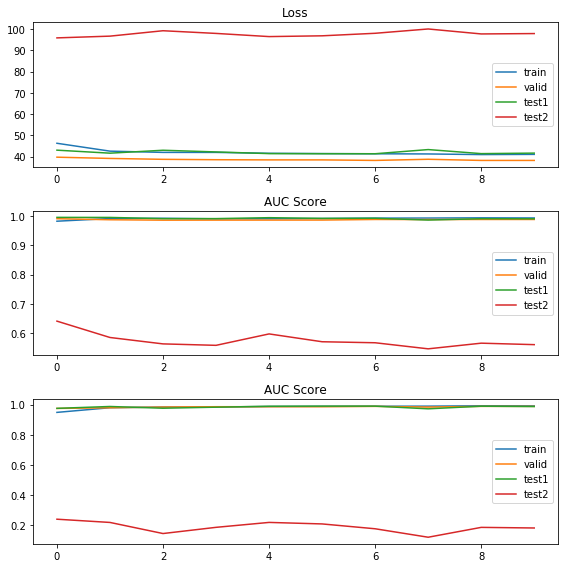

In [27]:
save = "baseline"

train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
test1_loss = [l['loss'] for l in history['test1']]
test2_loss = [l['loss'] for l in history['test2']]

train_auc = [l['auc'] for l in history['train']]
valid_auc = [l['auc'] for l in history['valid']]
test1_auc = [l['auc'] for l in history['test1']]
test2_auc = [l['auc'] for l in history['test2']]

train_f1 = [l['f1'] for l in history['train']]
valid_f1 = [l['f1'] for l in history['valid']]
test1_f1 = [l['f1'] for l in history['test1']]
test2_f1 = [l['f1'] for l in history['test2']]

plt.figure(figsize=(8,8))

plt.subplot(311)
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.plot(test1_loss, label='test1')
plt.plot(test2_loss, label='test2')
plt.legend()


plt.subplot(312)
plt.title('AUC Score')
plt.plot(train_auc, label='train')
plt.plot(valid_auc, label='valid')
plt.plot(test1_auc, label='test1')
plt.plot(test2_auc, label='test2')
plt.legend()
plt.tight_layout()

plt.subplot(313)
plt.title('AUC Score')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.plot(test1_f1, label='test1')
plt.plot(test2_f1, label='test2')
plt.legend()
plt.tight_layout()

# if save:
#     path = os.path.join("output", save+'.png')
#     plt.savefig(path)
plt.show()

# Adversarial training

# save model

# pytorch to tensorflow